In [ ]:
! pip install -U -q tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.2 MB/s eta 0:00:00


In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/cuckoo_audio_mono'
audio = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Species:', audio)

Species: ['Guira_Cuckoo' 'Pheasant_Cuckoo' 'Indian_Cuckoo']


In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(directory=data_dir,
                                                                batch_size=32,
                                                                validation_split=0.2,
                                                               seed=0,
                                                                output_sequence_length=None,
                                                                subset='both')

label_names = np.array(train_ds.class_names)

print()
print('label names:', label_names)

Found 300 files belonging to 3 classes.
Using 240 files for training.
Using 60 files for validation.

label names: ['Guira_Cuckoo' 'Indian_Cuckoo' 'Pheasant_Cuckoo']


In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for ex_audio, ex_labels in train_ds.take(1):
  print(ex_audio.shape)
  print(ex_labels.shape)

(32, 480000)
(32,)


In [ ]:
label_names[[1,1,0,2]]

array(['Indian_Cuckoo', 'Indian_Cuckoo', 'Guira_Cuckoo',
       'Pheasant_Cuckoo'], dtype='<U15')

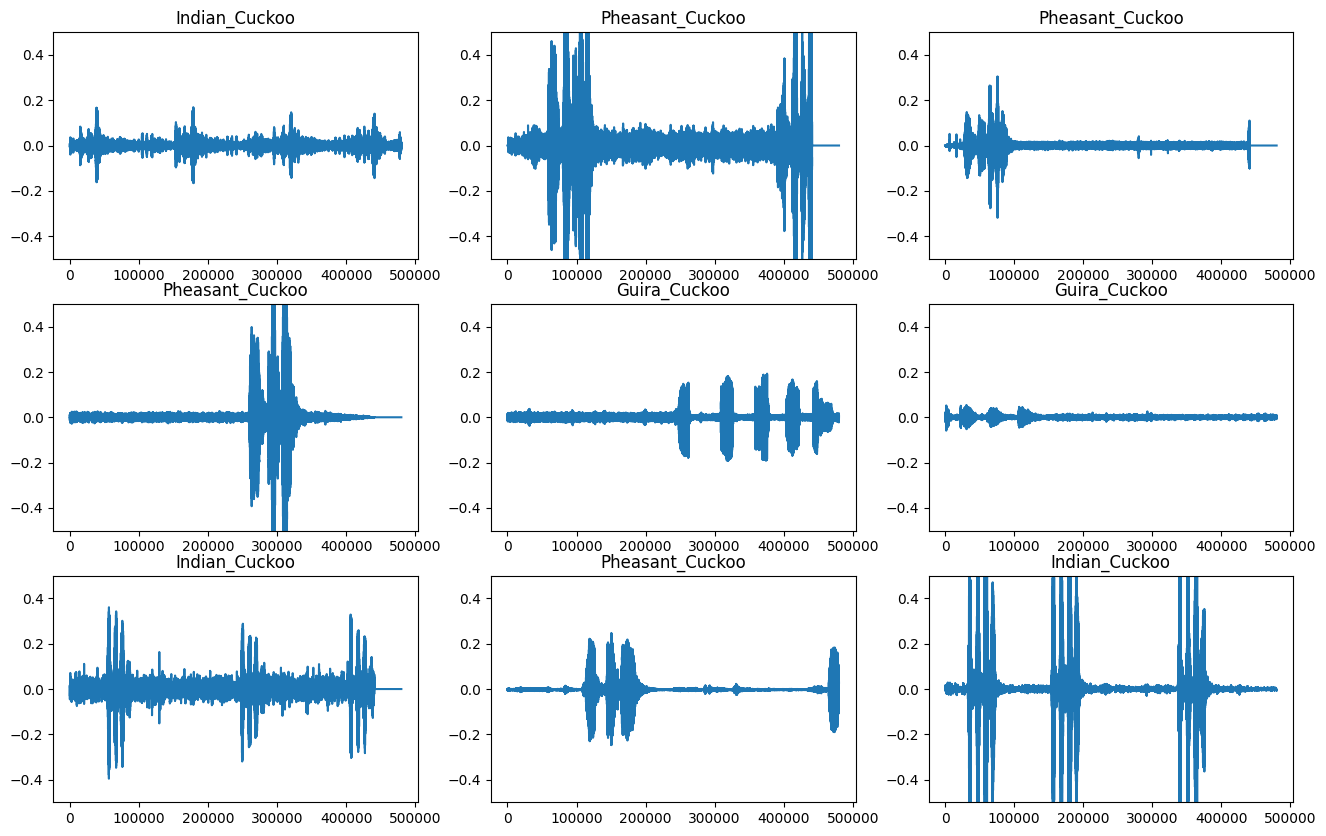

In [ ]:
plt.figure(figsize=(16,10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = ex_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[ex_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-0.5, 0.5])

### Converting Waveforms to Spectrograms

In [ ]:
def get_spectrogram(waveform):
  #Converting the waveform to a spectrogram via a STFT (Short time Fourier Transform)
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # To obtain the magnitude of the STFT
  spectrogram = tf.abs(spectrogram)
  # We also add a 'channels' dimension so spectrogram can be used as image-like
  #input data. ('batch_size', 'height', 'width', 'channels')
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram


In [ ]:
# Printing the shape of tensorized waveform
for i in range(3):
  label = label_names[ex_labels[i]]
  waveform = ex_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label: ', label)
  print('Waveform shape: ', waveform.shape)
  print('Spectrogram shape: ', spectrogram.shape)
  print('Audio Playback')
  display.display(display.Audio(waveform, rate=48000))

Label:  Indian_Cuckoo
Waveform shape:  (480000,)
Spectrogram shape:  (3749, 129, 1)
Audio Playback


Label:  Pheasant_Cuckoo
Waveform shape:  (480000,)
Spectrogram shape:  (3749, 129, 1)
Audio Playback


Label:  Pheasant_Cuckoo
Waveform shape:  (480000,)
Spectrogram shape:  (3749, 129, 1)
Audio Playback


In [ ]:
# !pip install pydub
# from pydub import AudioSegment
# wave = AudioSegment.from_file(file="/content/drive/MyDrive/Colab Notebooks/cuckoo_audio_mono/Indian_Cuckoo/Indian_Cuckoo005.wav", format="wav")
# print(wave.frame_rate)

48000


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
     # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)


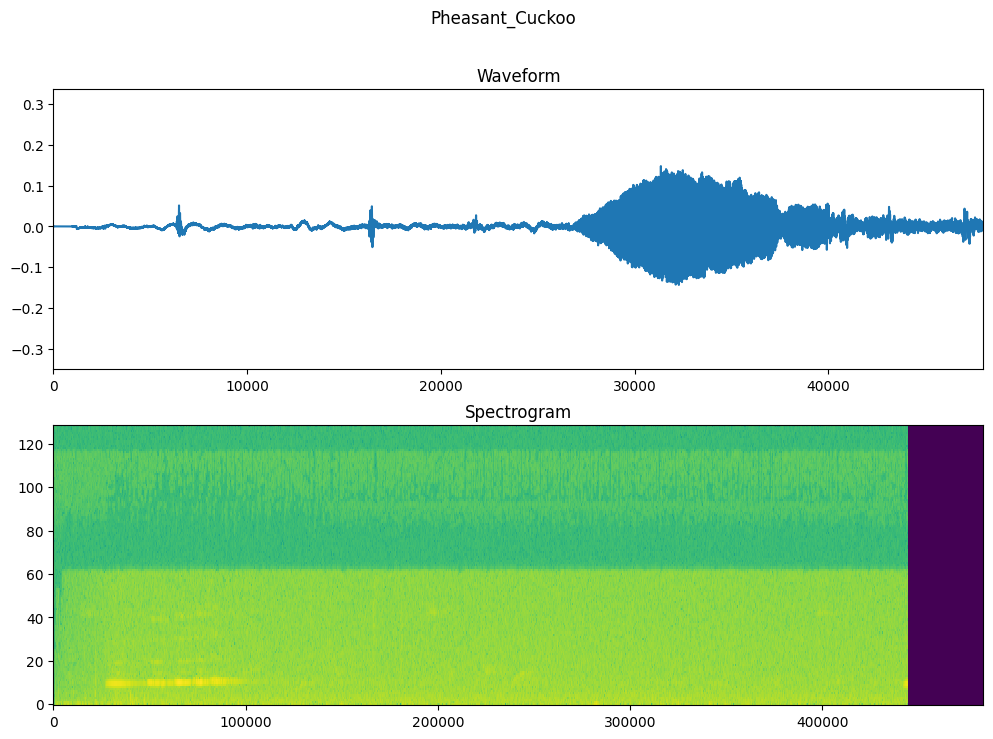

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 48000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()


In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func = lambda audio, label: (get_spectrogram(audio), label),
      num_parallel_calls = tf.data.AUTOTUNE)


In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break


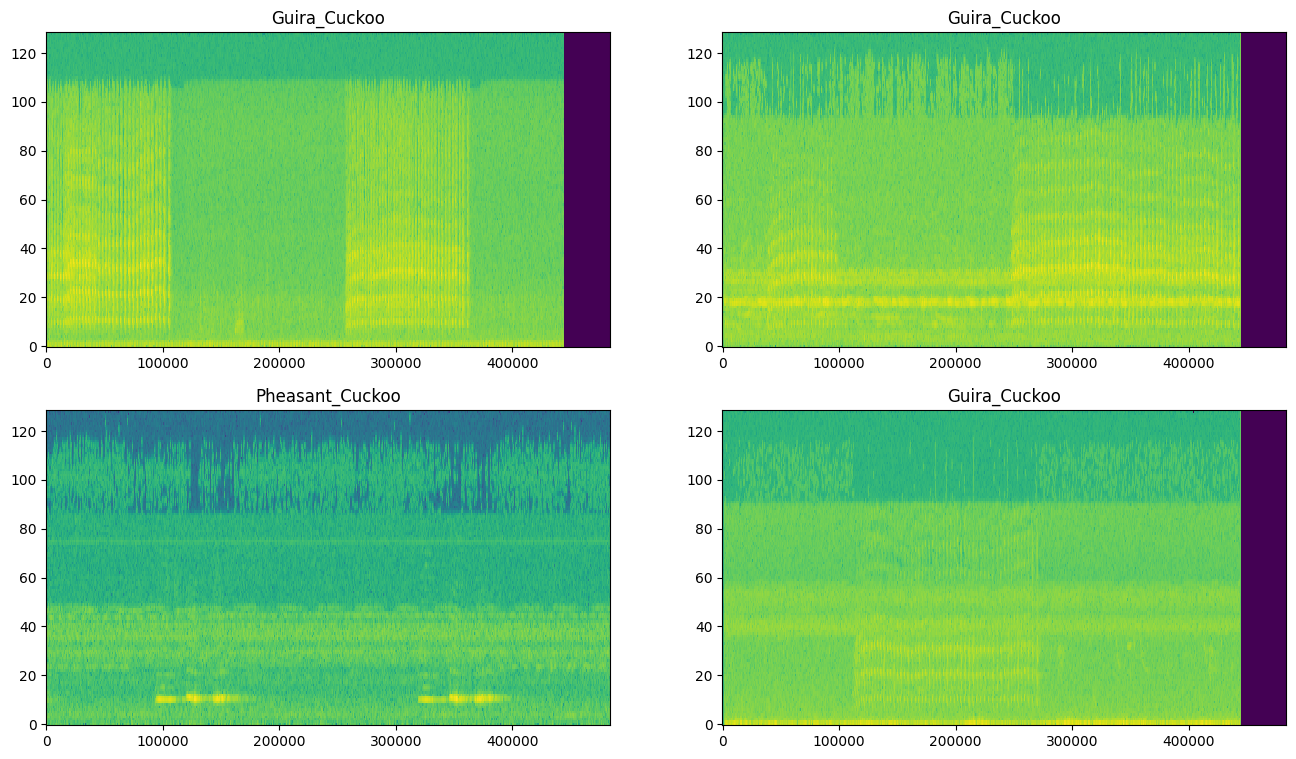

In [ ]:
rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()


## Building and Training the Model

We add Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)


## CNN model


We use tf.Keras.Sequential  
**tf.Keras.layers.Resizing**: To downsample the input to enable the model to train faster.  
**tf.Keras.layers.Normalization** :To normalize each pixel in the image based on its mean and standard deviation.

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input Shape:', input_shape)
num_labels = len(label_names)

#Instantiate the 'tf.keras.layers.Normalization' layer.
norm_layer = layers.Normalization()

# Fit the state of the layer to the spectrograms
# With 'Normalization.adapt'.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))


model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input Shape: (3749, 129, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_3 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)      

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data = val_spectrogram_ds,
    epochs =EPOCHS,
    callbacks = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    )


Epoch 1/10
8/8 [==============================] - 6s 713ms/step - loss: 1.0124 - accuracy: 0.4583 - val_loss: 1.1517 - val_accuracy: 0.4643
Epoch 2/10
8/8 [==============================] - 1s 146ms/step - loss: 0.7901 - accuracy: 0.6458 - val_loss: 0.8274 - val_accuracy: 0.6071
Epoch 3/10
8/8 [==============================] - 1s 107ms/step - loss: 0.6472 - accuracy: 0.7458 - val_loss: 0.6923 - val_accuracy: 0.8214
Epoch 4/10
8/8 [==============================] - 1s 108ms/step - loss: 0.5268 - accuracy: 0.7792 - val_loss: 0.6519 - val_accuracy: 0.8214
Epoch 5/10
8/8 [==============================] - 1s 95ms/step - loss: 0.4677 - accuracy: 0.8167 - val_loss: 0.5813 - val_accuracy: 0.8214
Epoch 6/10
8/8 [==============================] - 1s 98ms/step - loss: 0.4197 - accuracy: 0.8125 - val_loss: 0.5324 - val_accuracy: 0.7857
Epoch 7/10
8/8 [==============================] - 1s 110ms/step - loss: 0.3660 - accuracy: 0.8667 - val_loss: 0.5377 - val_accuracy: 0.7857
Epoch 8/10
8/8 [======

Text(0, 0.5, 'Accuracy [%]')

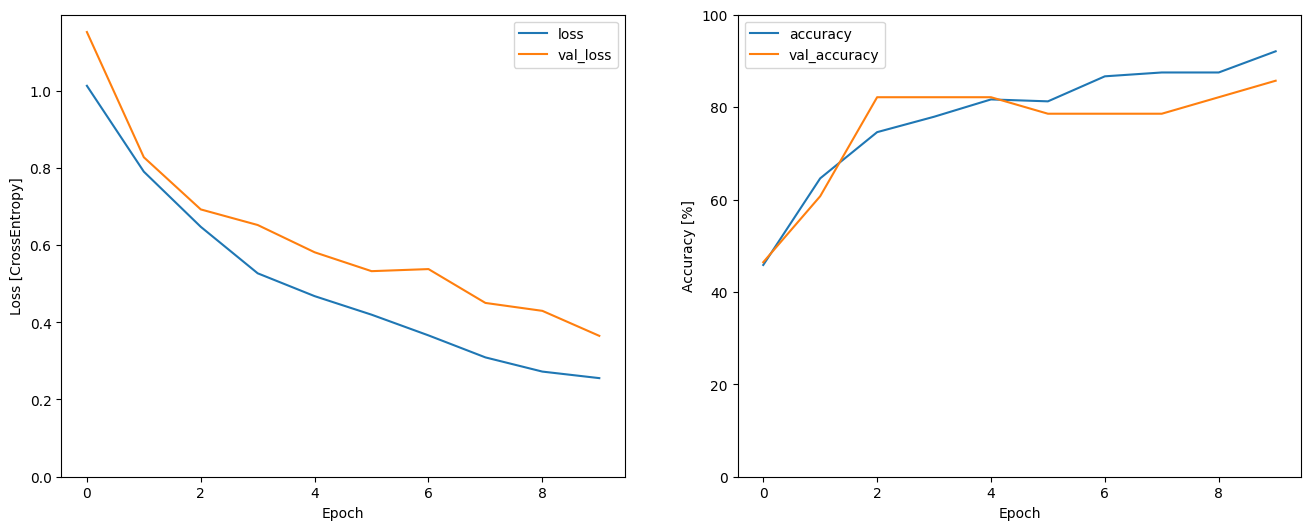

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')


In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 2s 2s/step - loss: 0.6849 - accuracy: 0.7500


{'loss': 0.6849232912063599, 'accuracy': 0.75}

In [ ]:
y_pred = model.predict(test_spectrogram_ds)

1/1 [==============================] - 0s 176ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)


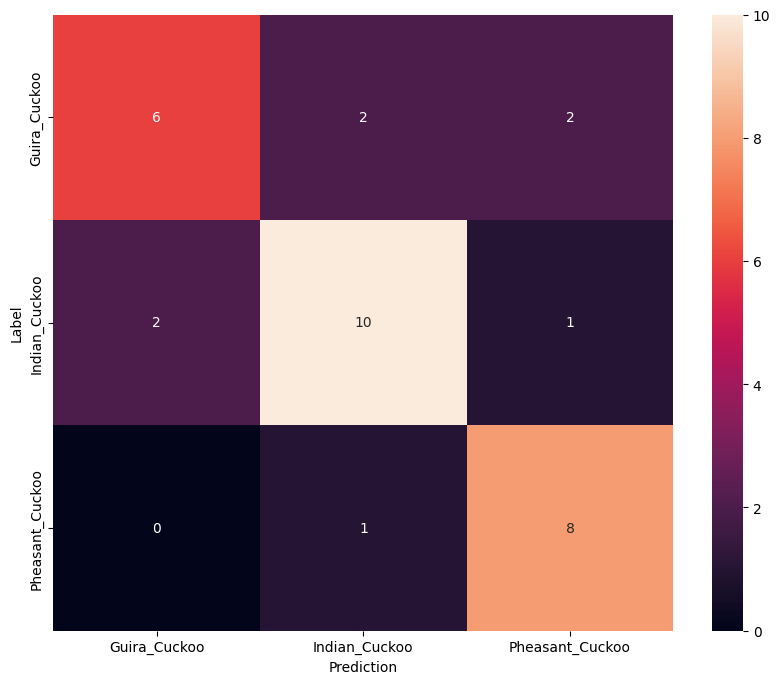

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


In [ ]:
x = '/content/drive/MyDrive/Colab Notebooks/cuckoo_audio_mono/Pheasant_Cuckoo/Pheasant_Cuckoo020.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_samples=48000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['Guira_Cuckoo', 'Indian_Cuckoo', 'Pheasant_Cuckoo']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.show()

display.display(display.Audio(waveform, rate=48000))


NameError: ignored